In [7]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import os
import random
import numpy as np
from torch import nn
from typing import Dict, Optional, Tuple, List
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, random_split
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report

In [8]:
SEED = 42

torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [1]:
!git clone https://github.com/uhh-lt/TextGraphs17-shared-task.git

Cloning into 'TextGraphs17-shared-task'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 172 (delta 16), reused 163 (delta 10), pack-reused 0
Receiving objects: 100% (172/172), 28.82 MiB | 7.37 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
!ls TextGraphs17-shared-task

data  evaluation  question_graph_examples  README.md  reformat_data  visualization


In [4]:
# train_path = "train.parquet"
# test_path = "test.parquet"

# train_dev_df = pd.read_parquet(train_path)
# test_df = pd.read_parquet(test_path)

In [10]:
train_dev_path = "TextGraphs17-shared-task/data/tsv/train_dev.tsv"

data_df = pd.read_csv(train_dev_path, sep='\t')

In [14]:
all_questions = list(data_df["question"].unique())
num_questions = len(all_questions)
random.shuffle(all_questions)

In [15]:
train_dev_ratio = 0.8
train_ratio = 0.9
num_train_dev_questions = int(num_questions * train_dev_ratio)
train_dev_questions = all_questions[:num_train_dev_questions]
test_questions = set(all_questions[num_train_dev_questions:])
num_train_questions = int(len(train_dev_questions) * train_ratio)
train_questions = set(train_dev_questions[:num_train_questions])
dev_questions = set(train_dev_questions[num_train_questions:])

print(f"Questions: train - {len(train_questions)}, dev - {len(dev_questions)}, test - {len(dev_questions)}")

Questions: train - 2544, dev - 283, test - 283


In [16]:
train_df = data_df[data_df["question"].isin(train_questions)]
dev_df = data_df[data_df["question"].isin(dev_questions)]
test_df = data_df[data_df["question"].isin(test_questions)]

print(f"Train: {train_df.shape}")
print(f"Dev: {dev_df.shape}")
print(f"Test: {test_df.shape}")

Train: (26934, 10)
Dev: (3006, 10)
Test: (7502, 10)


In [ ]:
train_df.loc[0, "graph"]

"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q65', 'id': 0, 'label': 'Los Angeles'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q100711983', 'id': 1, 'label': 'Category IIA'}, {'type': 'INTERNAL', 'name_': 'Q223596', 'id': 2, 'label': 'X-Men: First Class'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q44578', 'id': 3, 'label': 'Titanic'}], 'links': [{'name_': 'P915', 'source': 2, 'target': 0, 'label': 'filming location'}, {'name_': 'P8874', 'source': 2, 'target': 1, 'label': 'Hong Kong film rating'}, {'name_': 'P8874', 'source': 3, 'target': 1, 'label': 'Hong Kong film rating'}]}"

In [ ]:
train_df.head()

,sample_id,question,answerEntity,questionEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,graph,correct
0,0,Which actor was the star of Titanic and was bo...,Category IIA,Titanic\Los Angeles,Leonardo DiCaprio,Q100711983,"Q44578, Q65",Q38111,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_...",False
1,1,What is the seventh tallest mountain in North ...,Denali,North America,Mount Lucania,Q130018,Q49,Q1153188,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_...",False
2,2,Who is the youngest current US governor?,Andrew Cuomo,governor,Ron DeSantis,Q11673,Q889821,Q3105215,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30'...",False
3,3,Who is the youngest current US governor?,United States of America,governor,Ron DeSantis,Q30,Q889821,Q3105215,"{'nodes': [{'type': 'ANSWER_CANDIDATE_ENTITY',...",False
4,4,Who is the youngest current US governor?,governor,governor,Ron DeSantis,Q132050,Q889821,Q3105215,"{'nodes': [{'type': 'ANSWER_CANDIDATE_ENTITY',...",False


In [19]:
train_df["label"] = train_df["correct"].astype(np.float32)
dev_df["label"] = dev_df["correct"].astype(np.float32)
test_df["label"] = test_df["correct"].astype(np.float32)
train_df["label"].head(5)

<ipython-input-19-dfb9bda6aa0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["correct"].astype(np.float32)
<ipython-input-19-dfb9bda6aa0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["label"] = dev_df["correct"].astype(np.float32)
<ipython-input-19-dfb9bda6aa0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: label, dtype: float32

In [20]:
train_df["graph"] = train_df["graph"].apply(eval)
dev_df["graph"] = dev_df["graph"].apply(eval)
test_df["graph"] = test_df["graph"].apply(eval)

<ipython-input-20-3a975c0f4542>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["graph"] = train_df["graph"].apply(eval)
<ipython-input-20-3a975c0f4542>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["graph"] = dev_df["graph"].apply(eval)
<ipython-input-20-3a975c0f4542>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [24]:
train_df[["question", "answerEntity", "groundTruthAnswerEntity", "label"]].head(10)

,question,answerEntity,groundTruthAnswerEntity,label
0,Whose is the oldest MLB player to hit a home run?,Yogi Berra,Julio Franco,0.0
1,Whose is the oldest MLB player to hit a home run?,"Tony Gwynn, Jr.",Julio Franco,0.0
2,Whose is the oldest MLB player to hit a home run?,Roy Campanella,Julio Franco,0.0
3,Whose is the oldest MLB player to hit a home run?,Roger Clemens,Julio Franco,0.0
4,Whose is the oldest MLB player to hit a home run?,Mickey Mantle,Julio Franco,0.0
5,Whose is the oldest MLB player to hit a home run?,Lou Gehrig,Julio Franco,0.0
6,Whose is the oldest MLB player to hit a home run?,Julio Franco,Julio Franco,1.0
7,Whose is the oldest MLB player to hit a home run?,José Bautista,Julio Franco,0.0
8,Whose is the oldest MLB player to hit a home run?,Hank Greenberg,Julio Franco,0.0
9,Whose is the oldest MLB player to hit a home run?,Hank Aaron,Julio Franco,0.0


In [26]:
test_df[["question", "answerEntity", "groundTruthAnswerEntity", "label"]].head(10)

,question,answerEntity,groundTruthAnswerEntity,label
11,Whose assassination sparked the beginning of W...,assassination of Archduke Franz Ferdinand,Archduke Franz Ferdinand,0.0
12,Whose assassination sparked the beginning of W...,Franz-Joseph,Archduke Franz Ferdinand,0.0
13,Whose assassination sparked the beginning of W...,Franz Joseph I of Austria and Empress Elisabeth,Archduke Franz Ferdinand,0.0
14,Whose assassination sparked the beginning of W...,Franz Joseph I of Austria,Archduke Franz Ferdinand,0.0
15,Whose assassination sparked the beginning of W...,Franz Joseph,Archduke Franz Ferdinand,0.0
16,Whose assassination sparked the beginning of W...,Franz Ferdinand,Archduke Franz Ferdinand,0.0
17,Whose assassination sparked the beginning of W...,Emperor Franz Joseph I of Austria,Archduke Franz Ferdinand,0.0
18,Whose assassination sparked the beginning of W...,Emperor Franz Joseph I of Austria,Archduke Franz Ferdinand,0.0
19,Whose assassination sparked the beginning of W...,Archduke Franz Ferdinand car,Archduke Franz Ferdinand,0.0
20,Whose assassination sparked the beginning of W...,Archduke Franz Ferdinand,Archduke Franz Ferdinand,1.0


In [ ]:
class QuestionAnswerDataset(Dataset):

    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first"):
        super(QuestionAnswerDataset).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]
        assert len(self.questions) == len(self.contexts) == len(self.labels)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return {
                "input_ids": self.tokenized_input[idx]["input_ids"][0],
                "attention_mask" : self.tokenized_input[idx]["attention_mask"][0],
                "labels": self.labels[idx]}

NameError: name 'Dataset' is not defined

In [ ]:
# train_ratio=0.9
# train_df = train_dev_df.sample(frac=train_ratio)
# dev_df = train_dev_df.drop(train_df.index)

In [ ]:
# model_name="roberta-base"
model_name="sentence-transformers/all-mpnet-base-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

freeze_layer_count = 5
if freeze_layer_count > 0:
    for layer in bert_model.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

# Trainable params:  50206080


In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length)
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length)

In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
def train(model, iterator, optimizer, criterion, device,
          train_history=None, valid_history=None,):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):

        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())

    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion, device):
    model.eval()

    epoch_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            true_labels.extend(labels.cpu().numpy())
            labels = labels.to(device)


            output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = output.cpu().numpy()
            batch_pred_labels = (pred_probas >= 0.5) * 1

            loss = criterion(output, labels)

            pred_labels.extend(batch_pred_labels)
            epoch_loss += loss.item()

    valid_f1_score = f1_score(true_labels, pred_labels)
    return epoch_loss / (i + 1), valid_f1_score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [ ]:
def train_evaluate(bert_classifier, train_loader, dev_loader, optimizer, criterion, n_epochs,  checkpoint_fname, device):
    train_history = []
    valid_history = []
    valid_history_f1 = []

    best_valid_loss = float('inf')
    best_f1_score = 0.0

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(bert_classifier, train_loader, optimizer, criterion, device, train_history, valid_history, )
        valid_loss, valid_f1_score = evaluate(bert_classifier, dev_loader, criterion, device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_history_f1.append(valid_f1_score)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        clear_output(True)
        ax[0].plot(valid_history_f1, label='Val f1-score')
        ax[0].set_xlabel('Epoch')
        ax[0].set_title('Val f1-score')

        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].plot(valid_history, label='general valid history')

        plt.legend()
        plt.show()

        if valid_f1_score > best_f1_score:
            best_f1_score = valid_f1_score
            torch.save(bert_classifier.state_dict(), f'best-val-{checkpoint_fname}.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_f1_score:.3f}')

In [ ]:
def predict(model, data_loader, device):
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_true_labels = batch["labels"].cpu().numpy()


            pred_probas = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            true_labels.extend(batch_true_labels)
    return true_labels, pred_labels

In [ ]:
class BertSimpleClassifier(nn.Module):
    def __init__(self, bert_text_encoder, dropout=0.1):
        super().__init__()

        self.bert_text_encoder = bert_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        bert_hidden_dim = bert_text_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, bert_hidden_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, 1),
        )


    def forward(self, inputs, attention_mask,):
        last_hidden_states = self.bert_text_encoder(inputs, attention_mask=attention_mask,
                                                    return_dict=True)['last_hidden_state']
        text_cls_embeddings = torch.stack([elem[0, :] for elem in last_hidden_states])
        proba = self.classifier(text_cls_embeddings)
        return proba

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_simple_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_simple_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

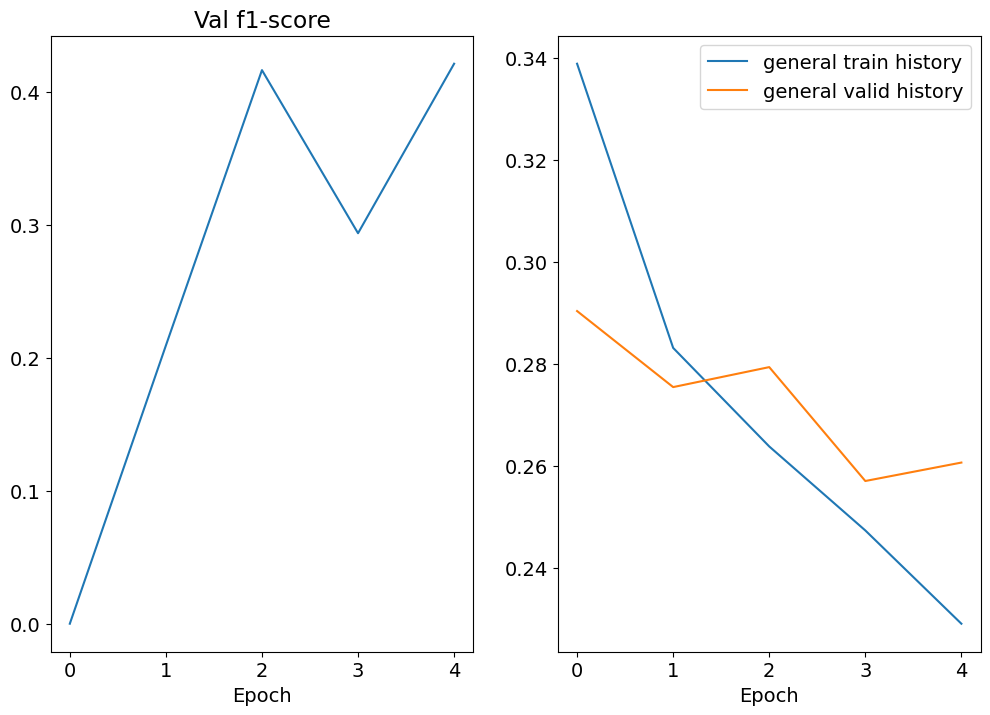

Epoch: 05 | Time: 24m 59s
	Train Loss: 0.229
	 Val. Loss: 0.261 |  Val. F1: 0.421


In [ ]:
train_evaluate(bert_simple_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "text_only_baseline", device)

In [ ]:
bert_simple_clf.load_state_dict(torch.load('best-val-text_only_baseline.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_simple_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.6419597989949749,0.3133047210300429,0.4210960032962505


### Evaluation on test set

In [ ]:
true_labels, pred_labels = predict(bert_simple_clf, test_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.609942638623327,0.2863554757630162,0.3897373243738546


In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels

In [ ]:
test_pred_path = "test_pred_mpnet_nograph_baseline.tsv"
test_df.to_csv(test_pred_path, sep='\t', index=False)
# test_df[["id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

In [ ]:
# del bert_simple_clf
# del bert_model
# del optimizer
# del criterion

## Linearized graph baseline

In [ ]:
SEP_TOKEN = tokenizer.sep_token

NameError: name 'tokenizer' is not defined

In [ ]:
# {'directed': True, 'multigraph': False, 'graph': {},
# 'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q49', 'id': 0, 'label': 'North America'},
# {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q194057', 'id': 1, 'label': 'Mount Rainier'}],
# 'links': [{'name_': 'P30', 'source': 1, 'target': 0, 'label': 'continent'}]}
def linearize_graph(graph_dict):
    nodes = sorted((node_dict for node_dict in graph_dict["nodes"]), key=lambda d:d["id"])
    for n_id, node_dict in enumerate(nodes):
        assert n_id == node_dict["id"]
    src_node_id2links = {}
    # print("graph_dict", graph_dict)
    # print("links", graph_dict["links"])
    for link_dict in graph_dict["links"]:
        link_src =  link_dict["source"]
        if src_node_id2links.get(link_src) is None:
            src_node_id2links[link_src] = []
        src_node_id2links[link_src].append(link_dict)
    graph_s = ""
    # print("src_node_id2links", src_node_id2links)
    for n_id, node_dict in enumerate(nodes):
        links = src_node_id2links.get(n_id, list())
        start_label = node_dict["label"]
        if node_dict["type"] == "ANSWER_CANDIDATE_ENTITY":
            start_label = f"{SEP_TOKEN} {start_label} {SEP_TOKEN}"
        for link_dict in links:
            target_label = nodes[link_dict["target"]]["label"]
            if nodes[link_dict["target"]]["type"] == "ANSWER_CANDIDATE_ENTITY":
                target_label = f"{SEP_TOKEN} {target_label} {SEP_TOKEN}"
            link_s = f" {start_label}, {link_dict['label']}, {target_label} "
            graph_s += link_s
        # graph_s += node_dict["label"]
        # print("n_id, node_dict", n_id, node_dict)
        # if n_id != len(nodes) - 1:


        #     link_label = link["label"]
        #     graph_s += link_label
    # print('--')
    return graph_s

In [ ]:
train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)
test_df["linearized_graph"] = test_df["graph"].apply(linearize_graph)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
train_df["linearized_graph"].head()

0           X-Men: First Class, filming location, Los Angeles  X-Men: First Class, Hong Kong film rating, </s> Category IIA </s>  Titanic, Hong Kong film rating, </s> Category IIA </s> 
1                                                                                             North America, highest point, </s> Denali </s>  </s> Denali </s>, continent, North America 
2     United States of America, country, United States of America  </s> Andrew Cuomo </s>, country of citizenship, United States of America  governor, country, United States of America 
3                                                 </s> United States of America </s>, country, </s> United States of America </s>  governor, country, </s> United States of America </s> 
4                                                                                                                                              governor, subclass of, </s> governor </s> 
Name: linearized_graph, dtype: object

In [ ]:
dev_df["linearized_graph"].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                United States of America, country, United States of America  Mississippi River, country, United States of America  Americans, country, United States of America  </s> Ambrose Bierce </s>, country of citizenship, United States of America 
1                                                                                                                                                                                                                                                                                                                                    Azerbaijan, on focus list of Wikimedi

In [ ]:
test_df["linearized_graph"].head()

0                                                                                                                                                                                                                                                                                                                                                                      People's Republic of China, country, People's Republic of China  People's Republic of China, language used, </s> Wa </s>  </s> Wa </s>, country, People's Republic of China 
1                                                                                                                                                                                                                                                                                                                                                                        Egyptian, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4  </s> Nefertiti </s>, on foc

In [ ]:
# model_name="roberta-base"
model_name="sentence-transformers/all-mpnet-base-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

freeze_layer_count = 5
if freeze_layer_count > 0:
    for layer in bert_model.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

# Trainable params:  50206080


In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                      tokenizer_truncation="only_second")
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                    tokenizer_truncation="only_second")
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

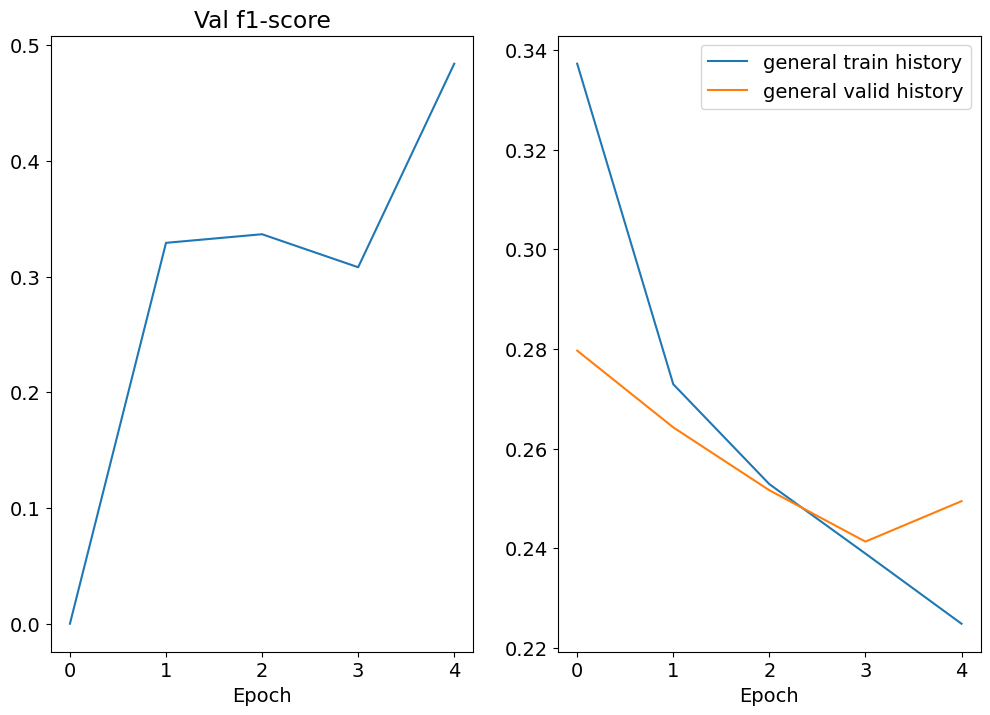

Epoch: 05 | Time: 24m 55s
	Train Loss: 0.225
	 Val. Loss: 0.249 |  Val. F1: 0.484


In [ ]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "bert_linearized_graph_clf", device)

In [ ]:
bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_clf.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.6281800391389433,0.39362354383813614,0.48398039954768196


### Evaluation on test set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.6308139534883721,0.3895870736086176,0.4816870144284129


In [ ]:
assert len(true_labels) == len(pred_labels)

In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


In [ ]:
test_df.head()

,sample_id,subset,question,answerEntity,questionEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,graph,correct,label,linearized_graph,true_y,prediction
0,0,public,Which of the top 5 longest rivers are not located in China?,Wa,People's Republic of China,Nile\Amazon River\Mississippi River\Yenisey,Q4923414,Q148,"Q3392, Q3783, Q1497, Q78707","{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q148', 'id': 0, 'label': 'People's Republic of China'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q4923414', 'id': 1, 'label': 'Wa'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P2936', 'source': 0, 'target': 1, 'label': 'language used'}, {'name_': 'P17', 'source': 1, 'target': 0, 'label': 'country'}]}",False,0.0,"People's Republic of China, country, People's Republic of China People's Republic of China, language used, </s> Wa </s> </s> Wa </s>, country, People's Republic of China",0.0,0
1,1,public,Which Egyptian queen ruled the longest?,Nefertiti,Egyptian,Hatshepsut,Q40930,Q50868,Q129234,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q6173448', 'id': 0, 'label': 'Wikipedia:Vital articles/Level/4'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q50868', 'id': 1, 'label': 'Egyptian'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q40930', 'id': 2, 'label': 'Nefertiti'}], 'links': [{'name_': 'P5008', 'source': 1, 'target': 0, 'label': 'on focus list of Wikimedia project'}, {'name_': 'P5008', 'source': 2, 'target': 0, 'label': 'on focus list of Wikimedia project'}]}",False,0.0,"Egyptian, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4 </s> Nefertiti </s>, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4",0.0,0
2,2,private,Which game in Animal Crossing series sold the most copies?,Category:Animal Crossing,Animal Crossing,Animal Crossing: New Horizons,Q8253315,Q1139803,Q64566657,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q1139803', 'id': 0, 'label': 'Animal Crossing'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q8253315', 'id': 1, 'label': 'Category:Animal Crossing'}], 'links': [{'name_': 'P910', 'source': 0, 'target': 1, 'label': 'topic's main category'}, {'name_': 'P301', 'source': 1, 'target': 0, 'label': 'category's main topic'}]}",False,0.0,"Animal Crossing, topic's main category, </s> Category:Animal Crossing </s> </s> Category:Animal Crossing </s>, category's main topic, Animal Crossing",0.0,0
3,3,public,Who is the actor that played John Kramer in Saw?,Category:Saw (franchise),John Kramer\Saw,Tobin Bell,Q8706244,"Q12320195, Q1145690",Q310190,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q6581097', 'id': 0, 'label': 'male'}, {'type': 'INTERNAL', 'name_': 'Q31', 'id': 1, 'label': 'Belgium'}, {'type': 'INTERNAL', 'name_': 'Q35', 'id': 2, 'label': 'Denmark'}, {'type': 'INTERNAL', 'name_': 'Q4167836', 'id': 3, 'label': 'Wikimedia category'}, {'type': 'INTERNAL', 'name_': 'Q312051', 'id': 4, 'label': 'Ken Leung'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1145690', 'id': 5, 'label': 'Saw'}, {'type': 'INTERNAL', 'name_': 'Q486239', 'id': 6, 'label': 'Saw'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q8706244', 'id': 7, 'label': 'Category:Saw (franchise)'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q12320195', 'id': 8, 'label': 'John Kramer'}], 'links': [{'name_': 'P530', 'source': 2, 'target': 1, 'label': 'diplomatic relation'}, {'name_': 'P1963', 'source': 3, 'target': 1, 'label': 'properties for this type'}, {'name_': 'P21', 'source': 4, 'target': 0, 'label': 'sex or gender'}, {'name_': 'P910', 'source': 5, 'target': 7, 'label': 'topic's main category'}, {'name_': 'P161', 'source': 6, 'target': 4, 'label': 'cast member'}, {'name_': 'P179', 'source': 6, 'target': 5, 'label': 'part of the series'}, {'name_': 'P910', 'source': 6, 'target': 7, 'label': 'topic's main category'}, {'name_': 'P31', 'source': 7, 'target': 3, 'label': 'instance of'}, {'name_': 'P301', 'source': 7, 'target': 5, 'label': 'category's main topic'}, {'name_

In [ ]:
test_df[["question", "answerEntity", "groundTruthAnswerEntity", "true_y", "prediction", "label"]].head(50)

,question,answerEntity,groundTruthAnswerEntity,true_y,prediction,label
0,Which of the top 5 longest rivers are not located in China?,Wa,Nile\Amazon River\Mississippi River\Yenisey,0.0,0,0.0
1,Which Egyptian queen ruled the longest?,Nefertiti,Hatshepsut,0.0,0,0.0
2,Which game in Animal Crossing series sold the most copies?,Category:Animal Crossing,Animal Crossing: New Horizons,0.0,0,0.0
3,Who is the actor that played John Kramer in Saw?,Category:Saw (franchise),Tobin Bell,0.0,0,0.0
4,What was the first Mass Effect game to include Thane Krios?,PlayStation 4,Mass Effect 2,0.0,0,0.0
5,What is the name of Katniss Everdeen's sister?,film character,Primrose Everdeen,0.0,0,0.0
6,Which game in the Diablo series sold the most copies?,Template:Diablo series,Diablo III,0.0,0,0.0
7,Who released the album Powerslave?,Compass Point Studios,Iron Maiden,0.0,0,0.0
8,Was Michael Jackson or Prince born first?,Sony Music,Prince,0.0,0,0.0
9,Where is the actress who played Katniss in The Hunger Games from?,Los Angeles,Indian Hills,0.0,0,0.0


In [ ]:
test_pred_path = "test_pred_linearized_graph_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)